In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import os
import scipy

In [3]:
import sys
print(sys.version)

import platform
print(platform.python_version())

3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
3.10.12


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn, Tensor

In [5]:
from MOFormer_modded.transformer import Transformer, TransformerRegressor
from MOFormer_modded.dataset_modded import MOF_ID_Dataset
from MOFormer_modded.tokenizer.mof_tokenizer import MOFTokenizer
import yaml
from MOFormer_modded.model.utils import *

/home/sartaaj/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
qmof_df = pd.read_csv("qmof.csv")
qmof_df

/tmp/ipykernel_446781/1200223640.py:1: DtypeWarning: Columns (40,41,43,44,45,46,47,49,50,51,52,53,55,56,57,65,66,67,68,69,77,78,79,80,81,89,90,91,92,93) have mixed types. Specify dtype option on import or set low_memory=False.
  qmof_df = pd.read_csv("qmof.csv")


,qmof_id,name,info.formula,info.formula_reduced,info.mofid.mofid,info.mofid.mofkey,info.mofid.smiles_nodes,info.mofid.smiles_linkers,info.mofid.smiles,info.mofid.topology,...,outputs.hse06.energy_elec,outputs.hse06.net_magmom,outputs.hse06.bandgap,outputs.hse06.cbm,outputs.hse06.vbm,outputs.hse06.directgap,outputs.hse06.bandgap_spins,outputs.hse06.cbm_spins,outputs.hse06.vbm_spins,outputs.hse06.directgap_spins
0,qmof-8a95c27,ABACUF01_FSR,Ba2CuC6H14O16,Ba2CuC6H14O16,NaN,NaN,"['O', '[Ba]', '[Cu]']",['[O-]C=O'],O.[Ba].[Cu].[O-]C=O,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,qmof-019ba28,ABALOF_FSR,Cu12C36H56I16N4S4,Cu3C9H14I4NS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,qmof-830ed1c,ABAVIJ_FSR,Co4C48H32N8O16,CoC12H8N2O4,[Co].[O-]C(=O)c1ccncc1 MOFid-v1.rtl.cat0,Co.TWBYWOBDOCUKOW.MOFkey-v1.rtl,['[Co]'],['[O-]C(=O)c1ccncc1'],[Co].[O-]C(=O)c1ccncc1,rtl,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,qmof-5bd4a24,ABAVOP_FSR,Co4C48H32N8O16,CoC12H8N2O4,[Co].[O-]C(=O)c1ccncc1 MOFid-v1.rtl.cat0,Co.TWBYWOBDOCUKOW.MOFkey-v1.rtl,['[Co]'],['[O-]C(=O)c1ccncc1'],[Co].[O-]C(=O)c1ccncc1,rtl,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,qmof-644aab4,ABAXUZ_FSR,Zn2C50H32N6O8S4,ZnC25H16N3O4S2,NaN,NaN,['[Zn][Zn]'],"['[O-]C(=O)c1cccc(c1)c1nccs1', 'n1ccc(cc1)c1cc...",[O-]C(=O)c1cccc(c1)c1nccs1.[Zn][Zn].n1ccc(cc1)...,NaN,...,-811.553858,0.0,2.901747,2.246703,-0.655044,True,"[None, None]","[None, None]","[None, None]","[None, None]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20370,qmof-7aebbbb,tobacco_srsb_sym_3_on_2_sym_3_mc_0_L_2,Cu12C84H60N24,CuC7H5N2,N1=C[C](C=N1)C=Cc1cc(C=CC2=C[N]N=C2)cc(c1)C=CC...,Cu.IBPUNEAULYEGJU.MOFkey-v1.srs,['[Cu]'],['N1=C[C](C=N1)C=Cc1cc(C=CC2=C[N]N=C2)cc(c1)C=...,N1=C[C](C=N1)C=Cc1cc(C=CC2=C[N]N=C2)cc(c1)C=CC...,srs,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20371,qmof-9a04c15,tobacco_srsb_sym_3_on_2_sym_3_mc_0_L_6,Cu12C84H48N60,CuC7H4N5,N1=C[C](C=N1)n1nnc(c1)c1cc(cc(c1)c1nnn(c1)C1=C...,Cu.JWLDCPHWRGZUAB.MOFkey-v1.srs,['[Cu]'],['N1=C[C](C=N1)n1nnc(c1)c1cc(cc(c1)c1nnn(c1)C1...,N1=C[C](C=N1)n1nnc(c1)c1cc(cc(c1)c1nnn(c1)C1=C...,srs,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20372,qmof-0dce90f,tobacco_srsb_sym_3_on_2_sym_3_mc_0__,Cu12C60H36N24,CuC5H3N2,N1=C[C](C=N1)c1cc(cc(c1)C1=CN=N[CH]1)C1=C[N]N=...,Cu.PJSMFZDMZONQKK.MOFkey-v1.srs,"['[Cu]', '[Cu][Cu]']",['N1=C[C](C=N1)c1cc(cc(c1)C1=CN=N[CH]1)C1=C[N]...,N1=C[C](C=N1)c1cc(cc(c1)C1=CN=N[CH]1)C1=C[N]N=...,srs,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20373,qmof-955fe88,tobacco_srsb_sym_3_on_4_sym_3_mc_0_L_2,Cu12C112H72N24,Cu3C28H18N6,N1=C[C](C=N1)C=CC1=CC2=CC(=CC3=CC(=CC(=C1)[C]2...,Cu.WCJPEIPZJUESBA.MOFkey-v1.srs,['[Cu]'],['N1=C[C](C=N1)C=CC1=CC2=CC(=CC3=CC(=CC(=C1)[C...,N1=C[C](C=N1)C=CC1=CC2=CC(=CC3=CC(=CC(=C1)[C]2...,srs,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
qmof_df['outputs.pbe.bandgap']

0        0.632527
1        1.134232
2        0.345448
3        0.342645
4        1.973007
           ...   
20370    2.692705
20371    3.326284
20372    3.383629
20373    0.660589
20374    2.348021
Name: outputs.pbe.bandgap, Length: 20375, dtype: float64

In [8]:
qmof_mofid = pd.read_csv("QMOF_small_mofid.csv", header = None)
qmof_mofid.columns = ['MOFid', 'Band Gap']
qmof_mofid

,MOFid,Band Gap
0,[O-]C(=O)c1cc2c3c(c1)c(N(=O)=O)c(c1c3c(c(c2N(=...,2.201034
1,Cl[Cd].O=C1[N]NC(=O)c2c1nccc2&&fes.cat0,2.055500
2,[Zn].c1ccc2c(c1)N=C[N]2&&sod.cat0,3.677709
3,[Cu].[O-]C(=O)CCc1cccnc1&&sql.cat0,0.959976
4,Fc1cncc(c1C#Cc1c(F)cncc1F)F.[O-]C(=O)c1c(Cl)c(...,1.098963
...,...,...
7461,[O-]C(=O)c1cc(cc(c1)N(=O)=O)C(=O)[O-].[Zn].c1n...,2.038372
7462,O=C(c1ccncc1)N1CCN(CC1)C(=O)c1ccncc1.[O-]C(=O)...,1.747641
7463,COc1cc2ccc3c(c2cc1C(=O)[O-])ccc1c3cc(C(=O)[O-]...,1.665536
7464,[Ni].c1ccc(cn1)[CH][N][N][CH]c1cccnc1&&cdt.cat0,1.388292


In [9]:
id_smiles_stable = {'qmof_ID' : [],
                    'SMILES' : [],
                    'Band Gap' : []
                    }

for i in qmof_mofid['MOFid'].values:
    smiles = i.split('&&')[0]
    try:
        qmof_id = qmof_df[qmof_df['info.mofid.smiles'] == smiles]['qmof_id'].values[0]
        bandgap = qmof_mofid[qmof_mofid['MOFid'] == i]['Band Gap'].values[0]

        id_smiles_stable['SMILES'].append(smiles)
        id_smiles_stable['qmof_ID'].append(qmof_id)
        id_smiles_stable['Band Gap'].append(bandgap)
    except:
        pass

In [10]:
data_df = pd.DataFrame(id_smiles_stable)
data_df = data_df.dropna()
data_df

,qmof_ID,SMILES,Band Gap
0,qmof-02f9568,[O-]C(=O)c1cc2c3c(c1)c(N(=O)=O)c(c1c3c(c(c2N(=...,2.201034
1,qmof-f8ab6e6,Cl[Cd].O=C1[N]NC(=O)c2c1nccc2,2.055500
2,qmof-ac208a4,[Zn].c1ccc2c(c1)N=C[N]2,3.677709
3,qmof-d967b7b,[Cu].[O-]C(=O)CCc1cccnc1,0.959976
4,qmof-c7f2375,Fc1cncc(c1C#Cc1c(F)cncc1F)F.[O-]C(=O)c1c(Cl)c(...,1.098963
...,...,...,...
7185,qmof-87a0280,[O-]C(=O)c1cc(cc(c1)N(=O)=O)C(=O)[O-].[Zn].c1n...,2.038372
7186,qmof-c645675,O=C(c1ccncc1)N1CCN(CC1)C(=O)c1ccncc1.[O-]C(=O)...,1.747641
7187,qmof-b2c7c73,COc1cc2ccc3c(c2cc1C(=O)[O-])ccc1c3cc(C(=O)[O-]...,1.665536
7188,qmof-fcb8885,[Ni].c1ccc(cn1)[CH][N][N][CH]c1cccnc1,1.388292


In [11]:
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels


    def __len__(self):
        return len(self.features)


    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [12]:
tokenizer = MOFTokenizer("MOFormer_modded/tokenizer/vocab_full.txt")
config = yaml.load(open("MOFormer_modded/config_ft_transformer.yaml", "r"), Loader=yaml.FullLoader)
config['dataloader']['randomSeed'] = 0

In [13]:
print(config)

{'batch_size': 64, 'epochs': 200, 'eval_every_n_epochs': 1, 'fine_tune_from': './training_results/pretraining', 'trained_with': 'CGCNN', 'log_every_n_steps': 1, 'gpu': 'cuda:0', 'vocab_path': 'MOFormer_modded/tokenizer/vocab_full.txt', 'cuda': True, 'num_workers': 0, 'task': 'classification', 'optim': {'optimizer': 'Adam', 'init_lr': 5e-05, 'weight_decay': '1e-6'}, 'dataloader': {'valid_ratio': 0.15, 'test_ratio': 0.15, 'use_ratio': 1, 'randomSeed': 0}, 'dataset': {'data_name': 'QMOF', 'dataPath': './MOFormer_modded/dataset/core_ch4uptake_highP.csv'}, 'Transformer': {'ntoken': 4021, 'd_model': 512, 'nhead': 8, 'd_hid': 512, 'nlayers': 6, 'dropout': 0.1}}


In [16]:
from sklearn.model_selection import KFold

In [17]:
data = data_df.to_numpy()

kf = KFold(n_splits = 5, shuffle = True, random_state=42)

folds = []
for train_index, test_index in kf.split(data):
    train_fold, test_fold = data[train_index], data[test_index]
    folds.append(train_fold)

In [26]:
folds[0].shape, folds[1].shape, folds[2].shape, folds[3].shape, folds[4].shape

((5752, 3), (5752, 3), (5752, 3), (5752, 3), (5752, 3))

In [28]:
from MOFormer_modded.transformer import PositionalEncoding
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import math

class Transformer(nn.Module):

    def __init__(self, ntoken: int, d_model: int, nhead: int, d_hid: int,
                 nlayers: int, dropout: float = 0.1):
        super().__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout, batch_first=True)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.token_encoder = nn.Embedding(ntoken, d_model)
        self.d_model = d_model

        self.init_weights()

    def init_weights(self) -> None:
        # initrange = 0.1
        # self.encoder.weight.data.uniform_(-initrange, initrange)
        nn.init.xavier_normal_(self.token_encoder.weight)

    def forward(self, src: Tensor) -> Tensor:
        """
        Args:
            src: Tensor, shape [seq_len, batch_size]
            src_mask: Tensor, shape [seq_len, seq_len]

        Returns:
            output Tensor of shape [seq_len, batch_size, ntoken]
        """
        src = self.token_encoder(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        output = output[:, 0:1, :] #this was added in by me

        return output.squeeze(dim = 1) #this was added in by me
        #return output

In [29]:
class ClassificationTransformer(nn.Module):
    def __init__(self, transformer, input_dim = 512, hidden_dim = 256, output_dim = 1):
        super(ClassificationTransformer, self).__init__()
        self.transformer = transformer

        self.classification_head = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Linear(hidden_dim, 2)
        ) #nn.Sigmoid was here before

    def forward(self, x):
        x = self.transformer(x)
        x = x.mean(dim = 1)
        x = self.classification_head(x)

        return x

class RegressionTransformer(nn.Module):
    def __init__(self, model, mlp_hidden_dim=256):
        super(RegressionTransformer, self).__init__()
        
        #initialize model itself
        self.model = model

        #regression head
        self.regression_head = nn.Sequential(
            nn.Linear(512, mlp_hidden_dim),
            nn.ReLU(),
            nn.Linear(mlp_hidden_dim, 1)
        )
        
        #only updating MLP regression head
        #for params in self.model.parameters():
        #    params.requires_grad = False
                
    def forward(self, smiles):
        transformer_output = self.model(smiles)

        output = self.regression_head(transformer_output)
        
        return output

In [30]:
def _load_pre_trained_weights(model, mode = 'cgcnn'):
    """
    Taken from this repository: https://github.com/zcao0420/MOFormer/blob/main/finetune_transformer.py
    """
    try:
        # checkpoints_folder = os.path.join(self.config['fine_tune_from'], 'checkpoints')
        #checkpoints_folder = 'SSL/pretrained/transformer'
        checkpoints_folder = 'SSL/pretrained/cgcnn'
        if mode == 'geometric':
            checkpoints_folder = 'SSL/pretrained/geometric'

        elif mode == 'cgcnn':
            checkpoints_folder = 'SSL/pretrained/transformer'
        
        else:
            checkpoints_folder = 'SSL/pretrained/None'

        load_state = torch.load(os.path.join(checkpoints_folder, 'model_t_50.pth'),  map_location=config['gpu']) 
        model_state = model.state_dict()

        for name, param in load_state.items():
            if name not in model_state:
                print('NOT loaded:', name)
                continue
            else:
                print('loaded:', name)
            if isinstance(param, nn.parameter.Parameter):
                # backwards compatibility for serialized parameters
                param = param.data
            model_state[name].copy_(param)
        print("Loaded pre-trained model with success.")
    except FileNotFoundError:
        print("Pre-trained weights not found. Training from scratch.")

    return model

transformer_SMILES = Transformer(**config['Transformer'])
model_pre = _load_pre_trained_weights(model = transformer_SMILES, mode = 'cgcnn')

loaded: pos_encoder.pe
loaded: transformer_encoder.layers.0.self_attn.in_proj_weight
loaded: transformer_encoder.layers.0.self_attn.in_proj_bias
loaded: transformer_encoder.layers.0.self_attn.out_proj.weight
loaded: transformer_encoder.layers.0.self_attn.out_proj.bias
loaded: transformer_encoder.layers.0.linear1.weight
loaded: transformer_encoder.layers.0.linear1.bias
loaded: transformer_encoder.layers.0.linear2.weight
loaded: transformer_encoder.layers.0.linear2.bias
loaded: transformer_encoder.layers.0.norm1.weight
loaded: transformer_encoder.layers.0.norm1.bias
loaded: transformer_encoder.layers.0.norm2.weight
loaded: transformer_encoder.layers.0.norm2.bias
loaded: transformer_encoder.layers.1.self_attn.in_proj_weight
loaded: transformer_encoder.layers.1.self_attn.in_proj_bias
loaded: transformer_encoder.layers.1.self_attn.out_proj.weight
loaded: transformer_encoder.layers.1.self_attn.out_proj.bias
loaded: transformer_encoder.layers.1.linear1.weight
loaded: transformer_encoder.layer

In [31]:
if torch.cuda.is_available() and config['gpu'] != 'cpu':
    device = config['gpu']
    torch.cuda.set_device(device)
    config['cuda'] = True

else:
    device = 'cpu'
    config['cuda'] = False
print("Running on:", device)

Running on: cuda:0


In [32]:
#model = ClassificationTransformer(transformer = model_pre)
model = RegressionTransformer(model = model_pre)

In [33]:
criterion = nn.L1Loss()

optimizer = optim.Adam(model.regression_head.parameters(), lr = 0.01)
optimizer_t = optim.Adam(model.model.parameters(), lr = 0.00005)

In [35]:
#this is for evaluation
batch_size = 64

fifth_db = MOF_ID_Dataset(data = folds[4], tokenizer = tokenizer)

fifth_fold = DataLoader(
                        fifth_db, batch_size=batch_size, drop_last=True, shuffle=True
                    )

In [36]:
n_iter = 0
valid_n_iter = 0
best_valid_loss = np.inf
best_valid_mae = np.inf
best_valid_roc_auc = 0
best_srcc_valid = 0

num_epoch = 20

for i in range(4):
    print(f"Training model number: {i}")
    loss_history, val_history, srcc_val_history = [], [], []

    transformer_SMILES = Transformer(**config['Transformer'])
    model_pre = _load_pre_trained_weights(model = transformer_SMILES, mode = 'cgcnn')
    model = RegressionTransformer(model = model_pre)

    criterion = nn.L1Loss()

    optimizer = optim.Adam(model.regression_head.parameters(), lr = 0.01)
    optimizer_t = optim.Adam(model.model.parameters(), lr = 0.00005)

    model.train()
    some_fold = MOF_ID_Dataset(data = folds[i], tokenizer = tokenizer)

    n_fold = DataLoader(
                        some_fold, batch_size=batch_size, drop_last=True, shuffle=True
                    )
    
    for epoch_counter in range(num_epoch):
        loss_temp = []
        for bn, (input1, target) in enumerate(n_fold):
            if config['cuda']:
                input_var_1 = input1.to(device)
                #input_var_2 = input2.to(device)
            else:
                input_var_1 = input1.to(device)
                #input_var_2 = input2.to(device)
            
            if config['cuda']:
                #target_var = Variable(target_normed.to(device, non_blocking=True)) #experimenting with normalization vs non-norm
                target_var = Variable(target.to(device, non_blocking=True))
            else:
                #target_var = Variable(target_normed)
                target_var = Variable(target)
            
            if config['cuda']:
                model = model.to(device)

            target_var = target_var.reshape(-1, 1)

            # compute output
            output = model(input_var_1)
            output = output.reshape(-1, 1)

            loss = criterion(output, target_var)

            optimizer.zero_grad()
            optimizer_t.zero_grad()

            loss.backward()

            optimizer.step()
            optimizer_t.step()
            n_iter += 1

            loss_temp.append(loss.item())
        
        loss_history.append(np.mean(loss_temp))

        val_temp = []
        srcc_val_temp = []
        model.eval()
        with torch.no_grad():
            for bn, (input1, target) in enumerate(fifth_fold):
                if config['cuda']:
                    input_var_1 = input1.to(device)
                    #input_var_2 = input2.to(device)
                else:
                    input_var_1 = input1.to(device)
                    #input_var_2 = input2.to(device)
                
                
                if config['cuda']:
                    #target_var = Variable(target_normed.to(device, non_blocking=True))
                    target_var = Variable(target.to(device, non_blocking=True))
                else:
                    #target_var = Variable(target_normed)
                    target_var = Variable(target)

                target_var = target_var.reshape(-1, 1)
                # compute output
                output = model(input_var_1)
                output = output.reshape(-1, 1)

                loss_val = criterion(output, target_var)
                val_temp.append(loss_val.item())
                srcc_val_temp.append(scipy.stats.spearmanr(output.cpu().numpy(), target_var.cpu().numpy())[0])
        
        srcc_val_history.append(np.mean(srcc_val_temp))

        
        val_history.append(np.mean(val_temp))

        if epoch_counter % config['log_every_n_steps'] == 0:
            print(f'Epoch: {epoch_counter+1}, Batch: {bn}, Loss: {loss_history[-1]}, Val Loss: {val_history[-1]}, SRCC_test = {srcc_val_history[-1]}')
        
    torch.save(model.state_dict(), f'model_ft_bandgap_{i}.pth')

Training model number: 0
loaded: pos_encoder.pe
loaded: transformer_encoder.layers.0.self_attn.in_proj_weight
loaded: transformer_encoder.layers.0.self_attn.in_proj_bias
loaded: transformer_encoder.layers.0.self_attn.out_proj.weight
loaded: transformer_encoder.layers.0.self_attn.out_proj.bias
loaded: transformer_encoder.layers.0.linear1.weight
loaded: transformer_encoder.layers.0.linear1.bias
loaded: transformer_encoder.layers.0.linear2.weight
loaded: transformer_encoder.layers.0.linear2.bias
loaded: transformer_encoder.layers.0.norm1.weight
loaded: transformer_encoder.layers.0.norm1.bias
loaded: transformer_encoder.layers.0.norm2.weight
loaded: transformer_encoder.layers.0.norm2.bias
loaded: transformer_encoder.layers.1.self_attn.in_proj_weight
loaded: transformer_encoder.layers.1.self_attn.in_proj_bias
loaded: transformer_encoder.layers.1.self_attn.out_proj.weight
loaded: transformer_encoder.layers.1.self_attn.out_proj.bias
loaded: transformer_encoder.layers.1.linear1.weight
loaded: 

In [37]:
def SMILES_to_property(smiles, model, tokenizer, device):
    token = np.array([tokenizer.encode(smiles, max_length=512, truncation=True,padding='max_length')])
    token = torch.from_numpy(np.asarray(token))

    token = token.to(device)
    return model(token)

In [38]:
SMILES_to_property('[Zn]12.OC(=O)C1=CC=C(C=C1)C(O2)=O', model, tokenizer, device)

tensor([[3.3134]], device='cuda:0', grad_fn=<AddmmBackward0>)

Text(0.5, 1.0, 'Learning curve')

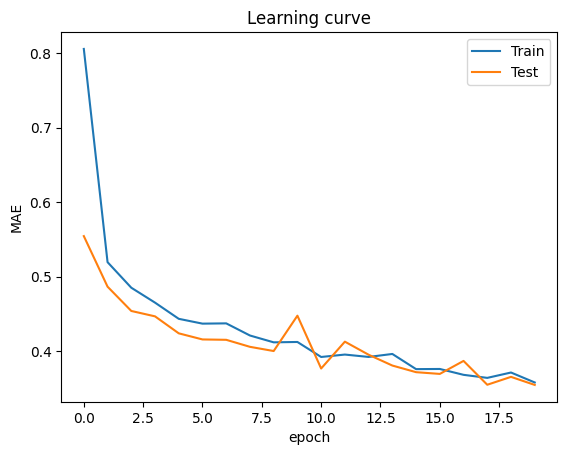

In [39]:
plt.plot(loss_history)
plt.plot(val_history)
plt.legend(['Train', 'Test'])
plt.xlabel('epoch')
plt.ylabel('MAE')
plt.title('Learning curve')